In [1]:
# Using drugMLpractical environment
# need python < 3.12 so I have 3.11, then just pip install matplotlib, pip install 'molflux[rdkit]

from molflux.datasets import load_dataset

dataset = load_dataset("esol")

print(dataset)

dataset[0]

/Users/irismarmouset-delataille/mambaforge/envs/drugMLpractical/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/irismarmouset-delataille/mambaforge/envs/drugMLpractical/lib/python3.11/site-packages/datasets/load.py:922: FutureWarning: The repository for esol contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /Users/irismarmouset-delataille/mambaforge/envs/drugMLpractical/lib/python3.11/site-packages/molflux/datasets/builders/esol/esol.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 1126 examples [00:00, 7311.08 examples/s]


Dataset({
    features: ['smiles', 'log_solubility'],
    num_rows: 1126
})


{'smiles': 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ',
 'log_solubility': -0.77}

In [2]:
from molflux.datasets import featurise_dataset
from molflux.features import load_from_dicts as load_representations_from_dicts

featuriser = load_representations_from_dicts(
    [
        {"name": "morgan"},
        {"name": "maccs_rdkit"},
    ]
)

featurised_dataset = featurise_dataset(dataset, column="smiles", representations=featuriser)

print(featurised_dataset)

Map: 100%|██████████| 1126/1126 [00:02<00:00, 543.77 examples/s]

Dataset({
    features: ['smiles', 'log_solubility', 'smiles::morgan', 'smiles::maccs_rdkit'],
    num_rows: 1126
})


In [3]:
from molflux.datasets import split_dataset
from molflux.splits import load_from_dict as load_split_from_dict

shuffle_strategy = load_split_from_dict(
    {
        "name": "shuffle_split",
        "presets": {
            "train_fraction": 0.8,
            "validation_fraction": 0.0,
            "test_fraction": 0.2,
        }
    }
)

split_featurised_dataset = next(split_dataset(featurised_dataset, shuffle_strategy))

print(split_featurised_dataset)

DatasetDict({
    train: Dataset({
        features: ['smiles', 'log_solubility', 'smiles::morgan', 'smiles::maccs_rdkit'],
        num_rows: 900
    })
    validation: Dataset({
        features: ['smiles', 'log_solubility', 'smiles::morgan', 'smiles::maccs_rdkit'],
        num_rows: 0
    })
    test: Dataset({
        features: ['smiles', 'log_solubility', 'smiles::morgan', 'smiles::maccs_rdkit'],
        num_rows: 226
    })
})


/Users/irismarmouset-delataille/mambaforge/envs/drugMLpractical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/irismarmouset-delataille/mambaforge/envs/drugMLpractical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{
    "explained_variance": 0.8,
    "max_error": 3.24,
    "mean_absolute_error": 0.71,
    "mean_squared_error": 0.92,
    "root_mean_squared_error": 0.96,
    "median_absolute_error": 0.53,
    "r2": 0.8,
    "spearman::correlation": 0.89,
    "spearman::p_value": 0.0,
    "pearson::correlation": 0.89,
    "pearson::p_value": 0.0
}


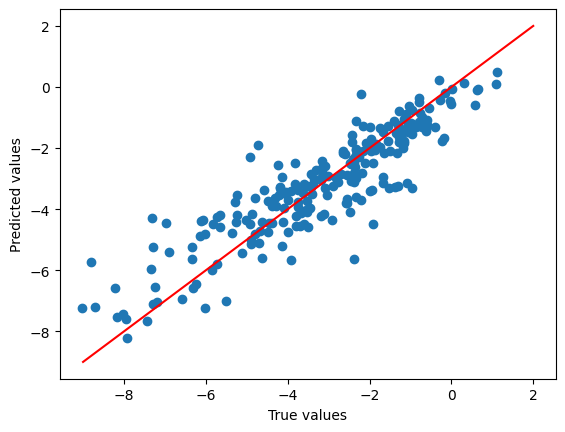

In [5]:
import json

from molflux.modelzoo import load_from_dict as load_model_from_dict
from molflux.metrics import load_suite

import matplotlib.pyplot as plt

model = load_model_from_dict(
    {
        "name": "random_forest_regressor",
        "config": {
            "x_features": ['smiles::morgan', 'smiles::maccs_rdkit'],
            "y_features": ['log_solubility'],
        }
    }
)

model.train(split_featurised_dataset["train"])

preds = model.predict(split_featurised_dataset["test"])

regression_suite = load_suite("regression")

scores = regression_suite.compute(
    references=split_featurised_dataset["test"]["log_solubility"],
    predictions=preds["random_forest_regressor::log_solubility"],
)

print(json.dumps({k: round(v, 2) for k, v in scores.items()}, indent=4))

plt.scatter(
    split_featurised_dataset["test"]["log_solubility"],
    preds["random_forest_regressor::log_solubility"],
)
plt.plot([-9, 2], [-9, 2], c='r')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

## Trying on our dataset

In [2]:
# Creating the clean dataset from the one provided 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import lazypredict as lz

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

def compute_descriptors(molecule):
    descriptors = {d[0]: d[1](molecule) for d in Descriptors.descList} 
    descriptors = pd.Series(descriptors) 
    return descriptors

def read_and_clean_data(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['r_avg_IC50', 'f_avg_IC50'], how='all')
    df = df.drop_duplicates(subset=['SMILES'], keep='first')
    df = df[df['f_avg_IC50']<=100] # removes extreme outliers
    dfs = df[['SMILES','CID','f_avg_IC50','r_avg_IC50']]
    return df, dfs

df, dfs = read_and_clean_data('raw_df_notest.csv')

# get all molecular descriptors
descriptors = dfs['SMILES'].apply(lambda smiles: compute_descriptors(Chem.MolFromSmiles(smiles)))
descriptors['CID'] = dfs['CID'].tolist()
# get Morgan fingerprints
dfs['FP'] = dfs['SMILES'].apply(lambda smiles: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048))
dfs['FP'] = dfs['FP'].apply(lambda fp: list(fp))


/var/folders/8c/nyqgv1692611ml62r5vpckym0000gn/T/ipykernel_26259/1293812107.py:20: DtypeWarning: Columns (4,7,8,10,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,37,41,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,250,254,255,256,257,258,259,260,265,266,267,268,269,270,271,276,277) have mixed types. Specify dtype option on im

In [3]:
dfs

,SMILES,CID,f_avg_IC50,r_avg_IC50,FP
24,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,DAR-DIA-23aa0b97-8,54.272964,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,DAR-DIA-23aa0b97-11,63.554925,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
105,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,WAR-XCH-eb7b662f-2,99.010000,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
124,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-3,4.222340,8.201698,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
127,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,TRY-UNI-714a760b-6,24.581194,13.895165,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
20371,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,0.052757,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20434,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,55.453947,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20435,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,0.050000,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20470,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,0.275118,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
# After creating a clean dataframe of the data, we need to convert it to a HuggingFace instance

from datasets import Dataset
import pandas as pd
data = Dataset.from_pandas(dfs)
print(data)
data[0]

Dataset({
    features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'FP', '__index_level_0__'],
    num_rows: 1713
})


{'SMILES': 'N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1',
 'CID': 'DAR-DIA-23aa0b97-8',
 'f_avg_IC50': 54.272963984987776,
 'r_avg_IC50': None,
 'FP': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [6]:
# Exctracting features

from molflux.datasets import featurise_dataset
from molflux.features import load_from_dicts as load_representations_from_dicts

featuriser = load_representations_from_dicts(
    [
        {"name": "morgan"},
        {"name": "maccs_rdkit"},
    ]
)

featurised_dataset = featurise_dataset(data, column="SMILES", representations=featuriser)

print(featurised_dataset)

Map:   0%|          | 0/1713 [00:00<?, ? examples/s]

Map: 100%|██████████| 1713/1713 [00:05<00:00, 336.35 examples/s]

Dataset({
    features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'FP', '__index_level_0__', 'SMILES::morgan', 'SMILES::maccs_rdkit'],
    num_rows: 1713
})


In [8]:
# Splitting the dataset 80-20

from molflux.datasets import split_dataset
from molflux.splits import load_from_dict as load_split_from_dict

shuffle_strategy = load_split_from_dict(
    {
        "name": "shuffle_split",
        "presets": {
            "train_fraction": 0.8,
            "validation_fraction": 0.0,
            "test_fraction": 0.2,
        }
    }
)

split_featurised_dataset = next(split_dataset(featurised_dataset, shuffle_strategy))

print(split_featurised_dataset)

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'FP', '__index_level_0__', 'SMILES::morgan', 'SMILES::maccs_rdkit'],
        num_rows: 1370
    })
    validation: Dataset({
        features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'FP', '__index_level_0__', 'SMILES::morgan', 'SMILES::maccs_rdkit'],
        num_rows: 0
    })
    test: Dataset({
        features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'FP', '__index_level_0__', 'SMILES::morgan', 'SMILES::maccs_rdkit'],
        num_rows: 343
    })
})


In [9]:
# Training the model 

current_model = 'logistic_regressor'

import json

from molflux.modelzoo import load_from_dict as load_model_from_dict
from molflux.metrics import load_suite

import matplotlib.pyplot as plt

model = load_model_from_dict(
    {
        "name": current_model,
        "config": {
            "x_features": ['SMILES::morgan'],
            "y_features": ['f_avg_IC50'],
            #'hidden_layer_sizes': [100, 10],
            #'train_features': ['SMILES::morgan']
            
        }
    }
)

model.train(split_featurised_dataset["train"])

preds = model.predict(split_featurised_dataset["test"])

regression_suite = load_suite("regression")

scores = regression_suite.compute(
    references=split_featurised_dataset["test"]["f_avg_IC50"],
    predictions=preds[current_model+"::f_avg_IC50"],
)

print(json.dumps({k: round(v, 2) for k, v in scores.items()}, indent=4))

plt.scatter(
    split_featurised_dataset["test"]["f_avg_IC50"],
    preds[current_model+"::f_avg_IC50"],
)
plt.plot([0, 100], [0, 100], c='r')
plt.xlabel("True values of f_avg_IC50")
plt.ylabel("Predicted values of f_avg_IC50")
plt.show()
print(model.config)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [19]:
from molflux.modelzoo import list_models

catalogue = list_models()

print(catalogue)

{'catboost': ['cat_boost_classifier', 'cat_boost_regressor'], 'core': ['average_regressor'], 'ensemble': ['ensemble_classifier', 'ensemble_regressor'], 'fortuna': ['fortuna_mlp_regressor'], 'lightning': ['lightning_mlp_regressor'], 'mapie': ['mapie_regressor'], 'pyod': ['abod_detector', 'cblof_detector', 'hbos_detector', 'isolation_forest_detector', 'knn_detector', 'mcd_detector', 'ocsvm_detector', 'pca_detector'], 'pystan': ['sparse_linear_regressor'], 'sklearn': ['bernoulli_nb_classifier', 'corrected_nb_classifier', 'coverage_nb_classifier', 'dummy_classifier', 'extra_trees_classifier', 'extra_trees_regressor', 'gradient_boosting_classifier', 'gradient_boosting_regressor', 'kernel_ridge_regressor', 'knn_classifier', 'knn_regressor', 'linear_discriminant_analysis_classifier', 'linear_regressor', 'logistic_regressor', 'mlp_classifier', 'mlp_regressor', 'pipeline_pilot_nb_classifier', 'pls_regressor', 'random_forest_classifier', 'random_forest_regressor', 'ridge_regressor', 'sklearn_pip